# Take-Home Challenge: Ultimate Technologies Inc.
*Fan Dong*

In [208]:
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

# Part I: Exploratory Data Analysis

Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand.

In [404]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


First we aggreget the login counts based on 15 minute time intervals and plot it to gain a general understanding of the login counts' distribution over time. 

In [405]:
logins['login_time'] = pd.to_datetime(logins['login_time'])

In [406]:
logins = logins.groupby(pd.Grouper(key='login_time', freq='15min')).size().reset_index()
logins.rename(columns={0: 'count'}, inplace=True)

In [407]:
logins.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


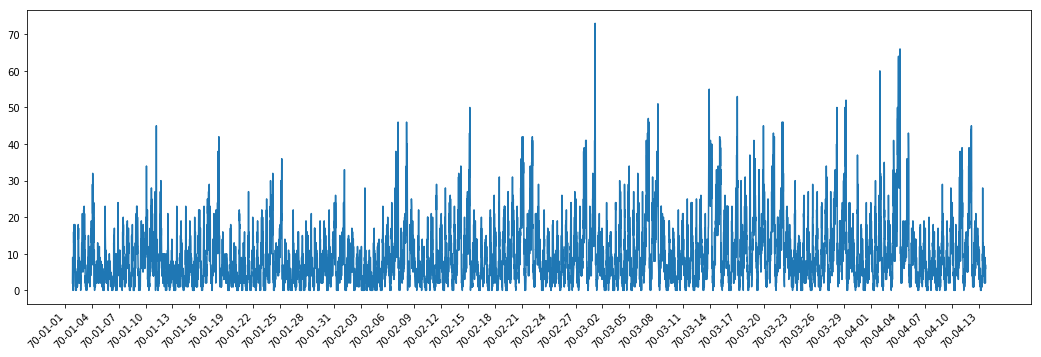

In [7]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
fig.autofmt_xdate()
xtick = pd.date_range(start='1/1/1970', end='4/13/1970', freq='3D')
plt.xticks(xtick, rotation=45)
plt.plot('login_time', 'count', data=logins)
xfmt = mdates.DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

According to the plot, there are definitely some time trends in login, as indicated by the up-and-downs at different times. The total login counts were generally increasing, especially in March and April. We need to aggregate the data by different time intervals to further examine the trends.

In [408]:
logins.set_index('login_time', inplace=True)

In [411]:
def resample_plot(df, interval, axis, title):
    """
    Plot the data by different time interval
    """
    temp = logins.resample(interval).sum()
    plt.subplot(axis)
    plt.xticks(rotation=45)
    plt.plot(temp['count'])
    plt.title(title)
    plt.tight_layout()

from pandas.tseries.offsets import *
def change_plot(f, axis, title):
    """
    Plot week-over-week over month-over-month change
    Input f can either be 'week' or 'month'
    """
    temp = logins.resample('D').sum()
    if f == 'week':
        temp2 = temp - temp.shift(1, freq=DateOffset(weeks=1))
    if f == 'month':
        temp2 = temp - temp.shift(1, freq=DateOffset(months=1))
    temp2.dropna(axis=0, how='all', inplace=True)
    plt.subplot(axis)
    plt.xticks(rotation=45)
    plt.plot(temp2['count'])
    plt.title(title)
    plt.tight_layout()   

def group_plot(f, axis, title):
    """
    Plot the average number of logins by weekday or hour
    Input f can either be 'weekday' or 'hour'
    """
    if f == 'weekday':
        temp = logins.resample('D').sum()
        temp['weekday'] = temp.index.weekday
        temp = temp.groupby([f])['count'].mean().reset_index()
    if f == 'hour':
        temp = logins.resample('60min').sum()
        temp['hour'] = temp.index.hour
        temp = temp.groupby([f])['count'].mean().reset_index()
    plt.subplot(axis)
    plt.plot(f, 'count', data=temp)
    plt.xlabel(f)
    plt.ylabel('Average Number of Logins')
    plt.title(title)
    plt.tight_layout()

The figures below show the login counts by different time intervals. The line plots smooth out as we lower the frequency from hourly to monthly. On a micro level, there are definitely daily and weekly trends, as the periodic patterns only exist in Hourly and Daily plots. We will investigate them further on the next set of plots. On a macro level, we can see an increasing trend from January to mid-April (ignore the sudden drops at the very end of the Weekly and Monthly plots, that is due to the fact that we don't have complete data for that last week/month). In general, the login count is on the rise. 

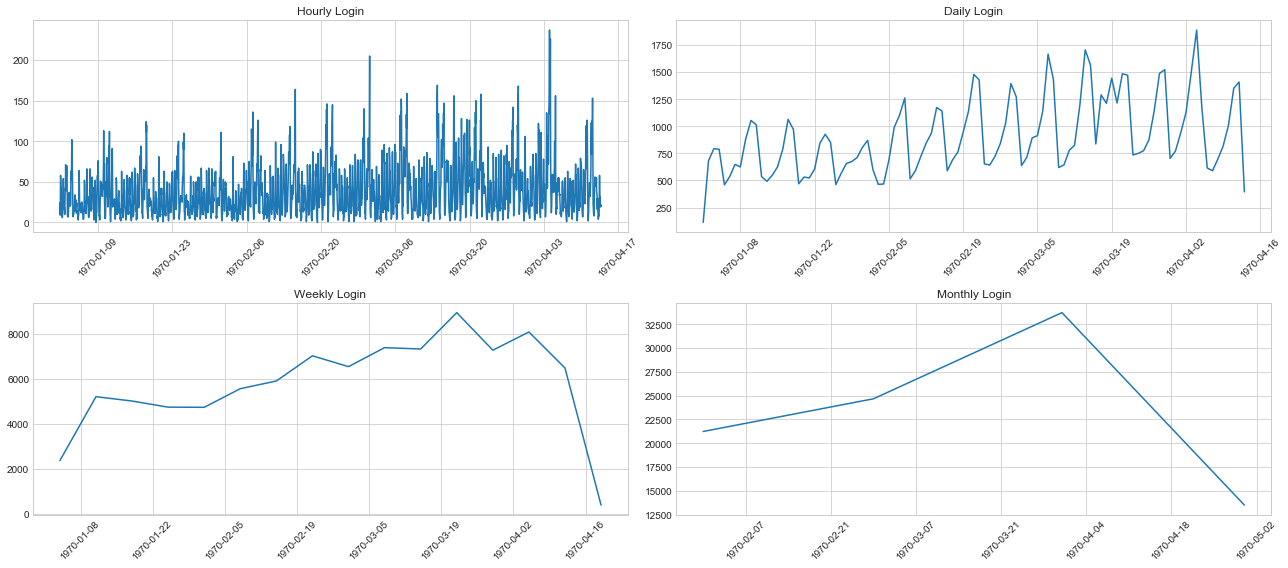

In [381]:
plt.rcParams['figure.figsize'] = (18, 8)
resample_plot(logins, '60min', 221, 'Hourly Login')
resample_plot(logins, 'D', 222, 'Daily Login')
resample_plot(logins, 'W', 223, 'Weekly Login')
resample_plot(logins, 'M', 224, 'Monthly Login')

### By Weekday and By Hour

The figures below show the average amount of logins by weekday and by hour. We learn the following facts from the figures:
- Number of logins increase as we are moving towards the weekends. It is at its peak on Friday and Saturday.
- Number of logins are low during working hours and high at noon and at late night.

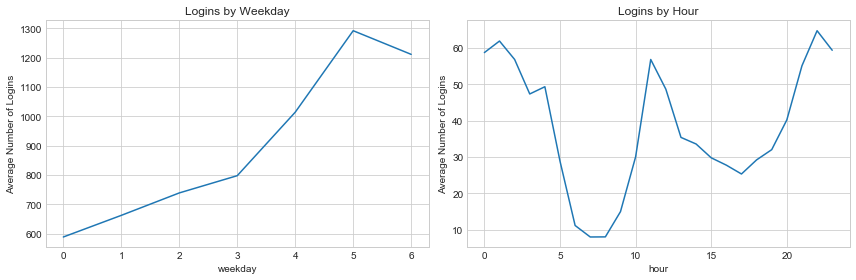

In [412]:
fig = plt.figure(figsize=(12,4))
group_plot('weekday', 121, 'Logins by Weekday')
group_plot('hour', 122, 'Logins by Hour')

### Plot the Changes

Moreover, we want to plot the week-over-week and month-over-month changes to see if there was any anomaly in a certain week/month. Both figures show that the changes became more volatile in March and April, likely due to the login increase at that time. 

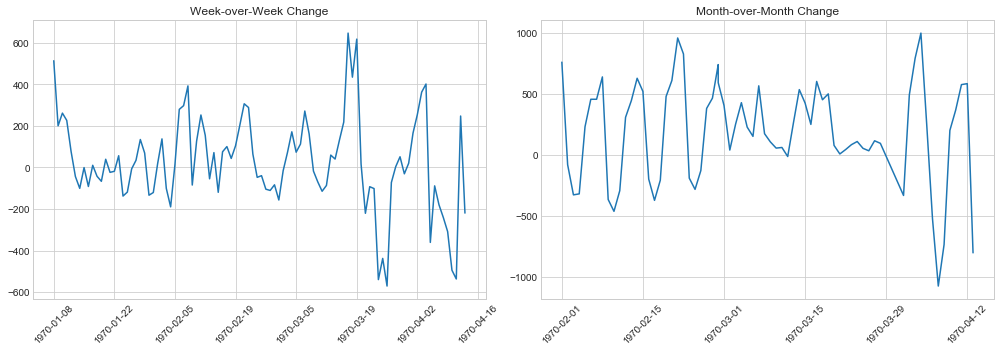

In [385]:
fig = plt.figure(figsize=(14,5))
change_plot('week', 121, 'Week-over-Week Change')
change_plot('month', 122, 'Month-over-Month Change')

### Summary

To conclude, we learn the following facts regarding login patterns:
- Between January and mid-April, there exists a general increasing trend in login counts.
- Daily and weekly cycles exist while monthly pattern is not detected.
- Number of logins increases as we approach weekends and reaches its peak on Friday and Saturday.
- Number of logins are low during working hours and high at noon and at late night.

# Part II: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

**Q1**. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I'd measure the number of completed rides. Given the context, on weekdays, during the day most rides will take place in Metropolis and at night in Gotham. On weekends, we expect similar amount of rides in both cities. The goal of the proposed toll-reimbursement plan is to re-free the market, encouraging the driver partners to go where they are most needed. The expectation is that more rider requests will be met, total number of completed rides will go up and on a city-time level, this number should be highly correlated with the active level of the city. Thus, if we are only choosing one, the number of completed rides should be the key metric to measure the success of this experiment. 


**Q2**. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on: a. how you will implement the experiment; b. what statistical test(s) you will conduct to verify the significance of the
observation; c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Randomly select half of the driver partners to the treatment group, with the rest being the control group. Make sure the selection is truly random in terms of the drivers' home city, active hours, service provided, vehicle types, etc. For a period of two weeks, the treatment group would receive the toll reimbursement (be sure notify the drivers at the very start of the experiment through a number of venues) while everything about the control group remains untouched. Choose an experiment period where no special event takes place in both cities. Run A-A test to make sure there is no difference in the two groups' key metrics.

Next, start the experiment and run it for two weeks. Gather the key metric (number of completed rides) data of both groups. Use two-sample t-test to test the null hypothesis that there is no difference in the two groups' key metric. If we reject the null hypothesis and the treatment group's number of completed rides is greater than that of the control group, we proceed to additional analysis.

- Compare the revenue generated by both groups, less the toll reimbursement expenses (for treatment group's calculation only). Did an increase in completed rides lead to increase in revenue?
- Compare the one-week retention rate before and after the experiment. In this comparison, the 'before' period should be one that is after the implementation of the toll and is comparable to the experiment period. Did the experiment increase the ease of getting a ride and thus increase the rider retention rate?

If the answers to the above questions are also 'yes', the  city operations team could consider provide 'toll reimbursement' for all drivers on Ultimate's platform. The team should also try to negotiate discounted toll charge with the two cities, as the increase in completed Ultimate rides (which is a form of carpool) can decrease private car usage, go hand in hand with public transportation and lead to more tax revenue.

# Part 3 ‑ Predictive modeling

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [312]:
with open('ultimate_data_challenge.json') as json_data:
    dat = json.load(json_data)
dat = pd.DataFrame(dat)

In [313]:
dat.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Identify Retained Users

We consider a user retained if they were “active” (i.e. took a trip) in their 6th month, that is, 5 months after they signed up.

In [314]:
dat['last_trip_date'] = pd.to_datetime(dat['last_trip_date'])
dat['signup_date'] = pd.to_datetime(dat['signup_date'])

In [315]:
dat['retained'] = dat['last_trip_date'] >= (dat['signup_date'] + datetime.timedelta(5*365/12))
dat['retained'].value_counts()

False    38806
True     11194
Name: retained, dtype: int64

In [316]:
print("Out of", dat.shape[0], 'users,',  "{:.0%}".format(11194 / dat.shape[0]), 
      "of them are retained users.")

Out of 50000 users, 22% of them are retained users.


## Feature Engineering and Exploratory Data Analysis

**Note:** We are under the assumption that in a real life scenario the goal of user retention prediction model is to identify retained/unretained users at a relatively early stage, that is, we won't have 6 month of data on a cohort of users, but less of them. Otherwise, length of active usage (last trip date - signup date) would be a great feature to be included in the model.

#### Deal with NAs

In [317]:
dat_nan = (dat.isnull().sum() / dat.shape[0]) * 100
dat_nan

avg_dist                   0.000
avg_rating_by_driver       0.402
avg_rating_of_driver      16.244
avg_surge                  0.000
city                       0.000
last_trip_date             0.000
phone                      0.792
signup_date                0.000
surge_pct                  0.000
trips_in_first_30_days     0.000
ultimate_black_user        0.000
weekday_pct                0.000
retained                   0.000
dtype: float64

Impute missing values with their median(numeric variable) or mode(str variable).

In [318]:
dat['avg_rating_by_driver'] = dat['avg_rating_by_driver'].fillna(value=dat['avg_rating_by_driver'].median())
dat['avg_rating_of_driver'] = dat['avg_rating_of_driver'].fillna(value=dat['avg_rating_of_driver'].median())
dat['phone'] = dat['phone'].fillna(value=dat['phone'].mode())

#### City, Phone, Black User

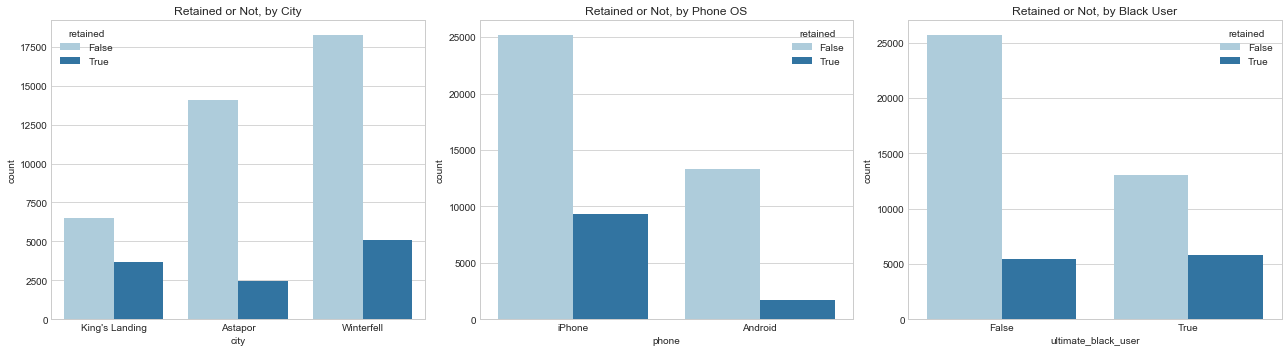

In [319]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
ax1 = sns.countplot(x="city", hue="retained", data=dat, palette="Paired", ax=ax[0])
ax1.set_title('Retained or Not, by City')
ax2 = sns.countplot(x="phone", hue="retained", data=dat, palette="Paired", ax=ax[1])
ax2.set_title('Retained or Not, by Phone OS')
ax3 = sns.countplot(x="ultimate_black_user", hue="retained", data=dat, palette="Paired", ax=ax[2])
ax3.set_title('Retained or Not, by Black User')
fig.tight_layout()

Key facts from the figures:
- Albeit a small market, King's Landing has a higher user retention rate than Astapor or Winterfell.
- iPhone users have mucher higher retention rate than Andriod's.
- Those who have used Black Car in their first 30 days have higher retention rate.

#### Average Rating by Driver, Surge Percentage, Weekday Percentage

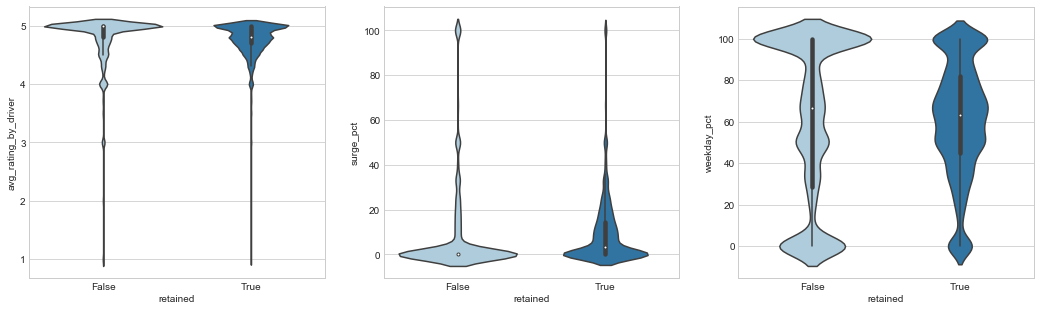

In [320]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
sns.violinplot(y='avg_rating_by_driver', x='retained', data=dat, palette="Paired", ax=ax[0])
sns.violinplot(y='surge_pct', x='retained', data=dat, palette="Paired", ax=ax[1])
sns.violinplot(y='weekday_pct', x='retained', data=dat, palette="Paired", ax=ax[2])
plt.show()

Key facts from the figures:
- Surprisingly, unretained riders gave a lot more 5-star rating than retained riders. There were more low ratings in retained riders.
- Retained riders have taken more surge rides.
- Unretained riders mostly took trips either during weekday or on weekends. The distribution between weekday and weekends was more even for retained drivers.

#### Weekday

Create variables indicating the weekday of the signup time and time of last ride.

In [321]:
dat['last_trip_weekday'] = dat['last_trip_date'].dt.weekday
dat['signup_weekday'] = dat['signup_date'].dt.weekday

#### Highly Correlated Variables

We suspect the surge variables to be highly correlated. If two variables have very high correlation, only one is needed to be included in the model. Let's check for their correlation.

In [322]:
cor = dat.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

surge_pct  avg_surge    0.793582
dtype: float64

The correlation between surge_pct and avg_surge is 0.8, which is acceptable. No need to drop any variable.

#### Convert String Variables to Dummies

String variables such as 'phone = 'iPhone'/'Andriod'' cannot be used directly in models. Thus, we convert them to binary dummies.

In [323]:
features = pd.get_dummies(dat, columns = ['city', 'phone'], prefix = ['city', 'os'])

In [324]:
features.columns.values

array(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       'retained', 'last_trip_weekday', 'signup_weekday', 'city_Astapor',
       "city_King's Landing", 'city_Winterfell', 'os_Android',
       'os_iPhone'], dtype=object)

#### Add Interactions

Create interaction terms to capture the interaction between city/phone dummies and the numeric variables. They can be particular useful for the Logistic regression model we built below, as logistic assumes linearity between response and predictive variables. Adding interaction terms provide additional flexibility to the model.

In [325]:
def create_interaction(df,var1,var2):
    name = var1 + "*" + var2
    df[name] = pd.Series(df[var1] * df[var2], name=name)

In [326]:
for i in ['surge_pct', 'weekday_pct', 'avg_surge', 'avg_dist', 'avg_rating_by_driver']:
    for j in ['city_Astapor',"city_King's Landing", 'city_Winterfell', 'os_Android','os_iPhone']:
        create_interaction(features, i, j)

### Prepare Feature Set and Target

In [327]:
features.drop(columns=['signup_date', 'last_trip_date', 'retained'], axis=1, inplace=True)

In [328]:
target = dat['retained']

## Fit Model

We applied Random Forest and Logistic Regression to build the predicative model. Random Forest (an ensemble of decision trees, where each tree is trained on a bootstrapped sample of the data using a random subset of the features) is a non-parametric machine learning model whild logistic regression is a traditional linear model that assumes linearity between predictive and response variables. Our test results show that random forest yields an AUC of 80.1% while that of Logistic is 72.2%. However, we still present both results below because of logistic's ease of interpretation.

### Test-Train Split and Undersample

The dataset is unbalanced with only 22% of the observations being 'retained'. Undersample the train set to construct more balanced model.

Test set's class ratio is unadjusted, mimicing the real situation.

We train on 75% of the data and test on the remaining 25%.

In [329]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from pprint import pprint
from sklearn import metrics

In [330]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)
rus = RandomUnderSampler(return_indices=True, random_state=0)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_train, y_train)

In [331]:
X_train = pd.DataFrame(X_resampled)
y_train = pd.DataFrame(y_resampled)[0]

Now, we have a balanced train set!

In [332]:
y_train.value_counts()

True     8447
False    8447
Name: 0, dtype: int64

### Random Forest

In [333]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 15, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]

In [334]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
pprint(random_grid)

{'max_depth': [5, 10, 15, 20, 25],
 'min_samples_split': [2, 5],
 'n_estimators': [2, 6, 10, 15]}


On each iteration, the algorithm will choose a difference combination of the features. 

#### Random Search Training

In [335]:
clf = RandomForestClassifier(n_jobs=-1)

In [336]:
# Use the random grid to search for best hyperparameters
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 5, cv=2, random_state=0, n_jobs = -1)

In [337]:
# Fit the random search model
clf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [2, 6, 10, 15], 'max_depth': [5, 10, 15, 20, 25], 'min_samples_split': [2, 5]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

** The best parameters are:**

In [338]:
clf_random.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 10}

In [339]:
clf=RandomForestClassifier(max_depth = 10, min_samples_split =2, n_estimators=10, n_jobs=-1, random_state = 0)

In [340]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

** Test the model**

In [341]:
y_pred = clf.predict_proba(X_test)[:,1]

In [342]:
metrics.roc_auc_score(y_test, y_pred)

0.8042526076656205

The random forest model has achieved an AUC of 80.4%.

In [343]:
y_pred_bin = clf.predict(X_test)

In [344]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bin, target_names=['Unretained', 'Retained']))

             precision    recall  f1-score   support

 Unretained       0.91      0.72      0.80      9753
   Retained       0.43      0.75      0.54      2747

avg / total       0.80      0.72      0.74     12500



The model performs better on the Unretained class, which is expected since it is the majority class. A high precision in unretained class indicates that most of the 'unretained' riders are predicted to be unretained. A high precision helps us identify the unretained riders more accurately so that more targeted marketing strategy can be applied. The precision of retained riders is relatively low. That should not be too much of a concern since the key is to understand how we retained them rather than accurately predict them.

### Logistic

In [345]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(fit_intercept=False, random_state=0)
logit.fit(X_train, y_train)
y_pred = logit.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred)

0.7225929120555479

The logistic regression model has achieved an AUC of 72.3%.

In [346]:
y_pred_bin = logit.predict(X_test)

In [347]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bin, target_names=['Unretained', 'Retained']))

             precision    recall  f1-score   support

 Unretained       0.87      0.67      0.76      9753
   Retained       0.36      0.65      0.46      2747

avg / total       0.76      0.67      0.69     12500



In almost all fields, logistic performs worse than  random forest.

## Interpretation

### Feature Importance

In [358]:
feature_importance = pd.DataFrame(clf.feature_importances_,index = features.columns,columns=['importance'])
imp=feature_importance.reset_index()
imp.columns=['names','importance']

In [359]:
imp = imp.sort_values('importance', ascending=False).reset_index()

Text(0.5,1,'Random Forest: Feature Importance')

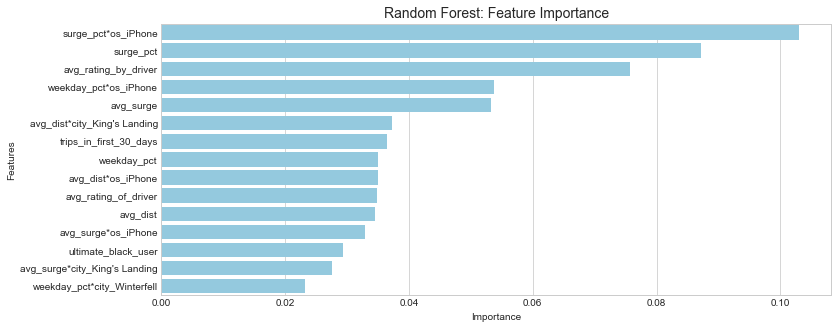

In [362]:
fig = plt.figure(figsize=(12,5))
sns.set_style("whitegrid")
ax = sns.barplot(x="importance", y="names", data=imp.iloc[0:15], color= "skyblue")
plt.setp(ax.patches, linewidth=0)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest: Feature Importance', fontsize='14')
#fig.savefig('rf importance.png')

The most important features picked by Random Forest are surge percentage, average rating by driver, weekday percentage, phone and average surge. However, we can't find out these impacts' direction from Random Forest. Let's dive deeper into the relation between response and predictive variables using the logistic model.

### Logistic's Scaled Coefficients

In [363]:
coef = pd.DataFrame()
coef['coef'] = logit.coef_[0]
coef['col'] = X_test.columns.values

In [364]:
coef['std'] = X_test[coef['col']].std(axis=0).reset_index()[0]

In [354]:
coef['std'].iloc[10:15] = 1
coef['std'].iloc[6] = 1
coef['scaled_coef'] = coef['std'] * coef['coef']

Below is the coefficients of our features returned by Logistic. Since our features have varying levels of scale, we 'scale' the coefficients for the ease of interpretation, that is, the scaled coefficient is the product of the feature's coefficient and its standard deviation. Given our data size, we can comfortably assume normality here. 

A positive coefficient indicates that the higher the variable value, the higher the probability of retaining the rider; a negative coefficient suggests the opposite. 

We learn the following facts from the figure:
- In line with our exploratory analysis, iPhone users are more likely to be retained than Andriod's, Ultimate Black users are more likely to be retained, and residents in King's Landing are more likely to be retained than those in Winterfell and Astapor.
- Our surprising finding in EDA still holds: average rating of driver is negatively correlated with the probability of retaining the rider. Unsatisfied riders are more likely to stay! This is especially true with iPhone users.
- The more trips the rider took in their first month, the more likely they would be retained, especially for residents in King's Landing and Winterfell.
- The more surged trips the rider took, the more likely they would be retained. This trend was more evident among Andriod users than iPhone users.
- Average distance is negatively correlated with predicted probability.

Text(0,0.5,'Column')

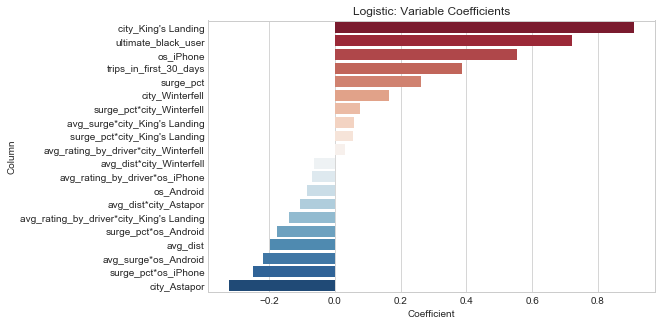

In [357]:
coef = coef.sort_values(by='scaled_coef', ascending=False)
fig = plt.figure(figsize=(8,5))
sns.barplot(x="scaled_coef", y="col", data=pd.concat([coef.head(10), coef.tail(10)]), palette="RdBu")
plt.title("Logistic: Variable Coefficients")
plt.xlabel('Coefficient')
plt.ylabel('Column')

## Summary

We consider a rider 'retained' if they take trips in their 6th month on the system. In our dataset, out of 50000 users, 22% of them were retained. Based on our exploratory analysis, the common characteristics of the retained users include living in King's Landing, using iPhone, giving more diverse ratings (not all 5-star) and taking rides both on weekends and during weekdays.

Next, we built a model predicting user retention using Random Forest method, given its flexibility(free of assumption between response and predictive variables) and high accuracy. The model had an AUC of 80.1% and an overall precision of 81% (91% in unretained class and 43% in retained class). For the purpose of interpretation, we also built a logistic model. Its performance was worse than Random Forest in almost all aspects.

We then dive deeper to understand the relation between response and predictive variables. Based on Random Forest's feature importance and Logistic regression's variable coefficients, we learn the following facts:
- **City:** King's Landing are more likely to be retained than those in Winterfell and Astapor.
- **Phone:** iPhone users are more likely to be retained than Andriod's.
- **Trips in the first 30 days:** The more trips the rider took in their first month, the more likely they would be retained.
- **Ultimate Black:** Ultimate Black users are more likely to be retained.
- **Surge:** The more surged trips the rider took, the more likely they would be retained. 
- ** Average distance:** Retained riders tend to make shorter trips.
- ** Average rating by driver:** Retained riders have lower average ratings. 

** Takeaways:**

Based on our findings, the team can consider the following approaches to increase customer retention:
- Why were users in King's Landing more likely to stay? What aspects of services in Winterfell and Astapor could be improved? Find out answers to these questions and fix them!
- Why were iPhone users more likely to stay? Was that due to better app experiences, better marketing strategy on iOS or their socioeconomic condition? Find out the answer and improve user experience for Andriod users.
- Encourage users to make more trips in their first 30 days! More marketing and sales plans targeting the new users (i.e., a 30-day pass).
- Encourage people to try Ultimate Black.
- Retained riders tend to make shorter trips. See if these trips took place in a certain area (i.e., around residents' home, daily commute route). It's possible to introduce 'regional pass' to this type of users.

However, before taking any action, it is important to first understand the direction of retention and key features’ interactions (in econometric term: endogeneity). Is X causing Y or is it the other way around? For example, in our model, average rating by driver is negatively correlated with the retention dummy. While lower average rating leads to more retained customers sound counter-intuitive, a more reasonable explanation may be: a retained/frequent rider of Ultimate is more likely to take the rating seriously and gives their honest opinions. The same logic applies to the ‘surge’ features. Thus, before coming up with any marketing/sales plans based on the findings, it is essential to take one step further and check for the endogeneity issue first.